# Import modules

Imports the required Python libraries and sets the random seed.

*Libraries:*
- `itertools`
- `numpy`
- `sklearn`
- `matplotlib`

In [ ]:
# Add GPU acceleration
%load_ext cuml.accel

cuML: Accelerator installed.


In [ ]:
# Import libraries
from itertools import combinations_with_replacement, combinations

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import r_regression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Set the random seed to allow for reproducibility
np.random.seed(42)

# Load dataset

Initializes the `matrix` and `vars`.

*Options:*

- Import data from a CSV

- Generate data from a function

In [ ]:
# Load dataset from file.
# PATH = "Data/example.csv"
# matrix = np.loadtxt(PATH, delimiter=',', dtype=float)
# vars = [f"x{i}" for i in range(matrix.shape[1] - 1)]

In [ ]:
# Generate dataset from equation.
NUM_ROWS = 10000
NUM_VARS = 4 # MODIFY THIS

vars = [f"x{i}" for i in range(NUM_VARS)]

matrix = np.empty((NUM_ROWS, NUM_VARS + 1))
matrix[:, 0:NUM_VARS] = np.random.rand(NUM_ROWS, NUM_VARS) * 20 - 10

x = []
for j in range(NUM_VARS):
  x.append(matrix[:, j])

matrix[:, NUM_VARS] = x[0]**2 + 2 * x[1] * (x[2] - x[3]) # MODIFY THIS

print("Vars:\n", vars, "\n")
print("Matrix:\n", matrix)

Vars:
 ['x0', 'x1', 'x2', 'x3'] 

Matrix:
 [[-2.50919762e+00  9.01428613e+00  4.63987884e+00  1.97316968e+00
   5.43730314e+01]
 [-6.87962719e+00 -6.88010959e+00 -8.83832776e+00  7.32352292e+00
   2.69719878e+02]
 [ 2.02230023e+00  4.16145156e+00 -9.58831011e+00  9.39819704e+00
  -1.53933161e+02]
 ...
 [ 9.16080848e+00  9.70494235e+00 -6.77194276e+00  1.21803843e+00
  -7.11642016e+01]
 [ 1.18297657e+00 -9.52386189e-01  8.49400317e+00  5.08067818e+00
  -5.10217358e+00]
 [ 5.29053871e+00 -4.60861136e+00 -1.31360456e+00 -2.51526030e-01
   3.77792142e+01]]


# Parameters and limitations

Defines the parameters/limitations for the analysis.

*Constants:*

- `TARGET_R2`: $R^2$ deemed enough for a successful model

  - Note: $R^2$ refers to the $r^2$ for the linear relationship between the actual and predicted function outputs

- `MAX_DEGREE`: Maximum polynomial power to consider

In [ ]:
TARGET_R2 = 0.99

In [ ]:
MAX_DEGREE = 4

# `Solution` class to represent the final equation

Defines a `Solution` class to cleanly store and display equation outputs

*Fields:*

- `score`: overall fit score for the equation ($R^2$)

- `terms`: array of tuples `[(coeffient1, var1), (coefficient2, var2), ...]`

- `intercept`: y-intercept of the equation (final constant term)

- `predicted_ys`: y-values predicted by the model for the dataset

- `actual_ys`: actual y-values from the original dataset

*Examples:*

- See `linear_regression` for an example of how to create a `Solution`

- See the "Run the algorithm" heading for an example of how using the `Solution` class helps display the equation

In [ ]:
class Solution:
  def __init__(self, score, terms, intercept, predicted_ys, actual_ys):
    self.score = score
    self.terms = terms
    self.intercept = np.float64(intercept)
    self.predicted_ys = predicted_ys
    self.actual_ys = actual_ys

  def __repr__(self):
    output = f"R^2 Score: {self.score}\n\n"

    for (coefficient, var) in self.terms:
      if coefficient**2 > 0.1: output += f"{coefficient.round(4)}*({var}) + "
    output += str(self.intercept.round(4))

    return output

  def visualize_actual_vs_predicted(self):
    plt.scatter(self.actual_ys, self.predicted_ys)
    plt.title(f"Actual vs Predicted Outputs (R^2 = {round(self.score, 4)})")
    plt.xlabel("Actual Outputs")
    plt.ylabel("Predicted Outputs")
    plt.show()

# Perform linear regression

Performs linear regression.

*Inputs:*

- `matrix`: rows represent observations; first columns are of independent/input variables, and the final column is of dependent/output variable

- `vars`: array of the variable names

In [ ]:
def linear_regression(matrix, vars):
  matrix = matrix.copy()
  vars = vars.copy()

  x_vals = matrix[:, :-1] # every column except last are independent input variables
  y_vals = matrix[:, -1] # last column is the dependent output variable we want to predict

  # Fit the model with remaining variables
  regression = LinearRegression()
  regression.fit(x_vals, y_vals)

  # Store and return the solution
  score = regression.score(x_vals, y_vals) # r^2
  coefficients = regression.coef_
  intercept = regression.intercept_
  terms = []

  for coefficient, var in zip(coefficients, vars):
    terms.append((coefficient, var))

  solution = Solution(score, terms, intercept, regression.predict(x_vals), y_vals)

  return solution

## Test

In [ ]:
# ----- Testing linear_regression ----- #

def test_linear_regression():
  # y = 3.75x0 + 2.4x1 + 3.6x2 + 12

  # Data
  test_vars = ["x0", "x1", "x2"]
  test_matrix = np.array ([ [  3,    -2,     2,    25.65],
                            [ -3,     0,     1,     4.35],
                            [ -4,     1,     1,     3.  ],
                            [  2,     1,    -1,    18.3 ],
                            [  2,    -1,    -4,     2.7 ],
                            [ -4,    -1,    -5,   -23.4 ],
                            [  1,     1,    -5,     0.15],
                            [ -5,    -4,    -5,   -34.35],
                            [ -5,     4,     4,    17.25],
                            [  0,     4,     1,    25.2 ],
                            [ -4,     5,     5,    27   ],
                            [  5,    -4,     2,    28.35],
                            [ -4,    -2,    -2,   -15   ],
                            [  3,     2,     2,    35.25],
                            [  0,     3,    -2,    12   ],
                            [ -1,    -1,     4,    20.25],
                            [  5,     0,     2,    37.95],
                            [ -2,     5,    -4,     2.1 ],
                            [  3,     1,    -5,     7.65],
                            [  0,     0,     0,    12] ])

  test_eq = linear_regression(test_matrix, test_vars)

  print(test_eq)

  # Making sure it worked
  assert repr(test_eq).split("\n")[2] == '3.75*(x0) + 2.4*(x1) + 3.6*(x2) + 12.0'

test_linear_regression()

R^2 Score: 1.0

3.75*(x0) + 2.4*(x1) + 3.6*(x2) + 12.0


# Generate polynomial features without cross terms

Generates polynomial features without cross terms (e.g., NO $x_1^n \times x_2^m$).

*Inputs:*

- `matrix`: rows represent observations; first columns are of independent/input variables, and the final column is of dependent/output variable

- `vars`: array of the variable names

- `degree`: maximum degree

In [ ]:
def generate_polynomial_features_no_cross(matrix, vars, degree=MAX_DEGREE):
  # Create output storage
  new_mat = np.empty(shape=[matrix.shape[0], 0])
  new_vars = []

  # Generate polynomials
  for var in range(len(vars)): # Fill in every column but the last one (reserved for the dependent variable)
    curr_var_column = matrix[:,var]
    for power in range(1, degree + 1):
      new_feature = curr_var_column ** power
      new_vars.append("*".join([f"({vars[var]})" for i in range(power)]))
      new_mat = np.hstack((new_mat, new_feature.reshape(-1, 1)))

  # Add back the dependent variable column and return as a tuple (to enable unpacking in lin_reg with the "*" operator)
  new_mat = np.hstack((new_mat, matrix[:, [-1]]))

  return (new_mat, new_vars)

## Test

In [ ]:
# ----- Testing generate_polynomial_features_no_cross ----- #
def test_generate_polynomial_features_no_cross():

    # Variable names
    test_vars = ["x1", "x2", "x3"]

    # Original data
    test_matrix = np.array([[0,1,2,1],[-1,2,-3,2]])

    # Expected output
    answer= np.array([[0,0,0,1,1,1,2,4,8,1],[-1,1,-1,2,4,8,-3,9,-27,2]])

    # Calling method
    out_matrix, out_vars = generate_polynomial_features_no_cross(test_matrix,test_vars,degree=3)

    print(f"Original Data:\n{test_vars}\n{test_matrix}")
    print(f"\nTransformed Data:\n{out_vars}\n{out_matrix}")
    assert (out_matrix==answer).all()

test_generate_polynomial_features_no_cross()

Original Data:
['x1', 'x2', 'x3']
[[ 0  1  2  1]
 [-1  2 -3  2]]

Transformed Data:
['(x1)', '(x1)*(x1)', '(x1)*(x1)*(x1)', '(x2)', '(x2)*(x2)', '(x2)*(x2)*(x2)', '(x3)', '(x3)*(x3)', '(x3)*(x3)*(x3)']
[[  0.   0.   0.   1.   1.   1.   2.   4.   8.   1.]
 [ -1.   1.  -1.   2.   4.   8.  -3.   9. -27.   2.]]


# Detect symmetries

Trains the MLP model and finds symmetries.

*Key Terms:*

- `a_alpha`: translational delta (nudge value) for symmetry detection for addition/subtraction

- `m_alpha`: translational delta (nudge value) for symmetry detection for multiplication/division

## Train MLP model

*Inputs:*

- `matrix`: rows represent observations; first columns are of independent/input variables, and the final column is of dependent/output variable

In [ ]:
# Train MLP model
# matrix: rows represent observations; first columns are of independent/input variables, and the final column is of dependent/output variable
def train_mlp_model(matrix):
  print("  -> TRAINING MODEL...")
  new_mat = matrix.copy()

  X_vals = new_mat[:, :-1] # every column except last are independent input variables
  y_vals = new_mat[:, -1] # last column is the dependent output variable we want to predict

  # x_train, y_train, x_test, y_test = x_vals[:int(len(x_vals)*0.8)], y_vals[:int(len(y_vals)*0.8)], x_vals[int(len(x_vals)*0.8):], y_vals[int(len(y_vals)*0.8):
  X_train, X_test, y_train, y_test = train_test_split(X_vals, y_vals, test_size=0.2, shuffle=True)

  mlp = MLPRegressor((500, 200, 100, 50, 20, 10), max_iter=100_000, early_stopping=True)
  mlp.fit(X_train, y_train)

  return mlp, mlp.score(X_test, y_test), X_test, y_test

## Check for symmetries between columns

*Inputs:*

- `i`: index of first column to consider

- `j`: index of second column to consider

- `col1`: first column to consider

- `col2`: second column to consider

- `mlp`: trained multi-layer perceptron regressor

- `a_alpha`: nudge value for symmetry detection for addition/subtraction

- `m_alpha`: nudge value for symmetry detection for multiplication/division

- `X_test`: matrix of the test independent variable values

- `y_test`: list of the test dependent variable values

- `old_score`: original R^2 value without translation

In [ ]:
# Check for subtractive symmetry
# i: index of first column to consider
# j: index of second column to consider
# col1: first column to consider
# col2: second column to consider
# mlp: trained multi-layer perceptron regressor
# a_alpha: nudge value for symmetry detection for addition/subtraction
# X_test: matrix of the test independent variable values
# y_test: list of the test dependent variable values
# old_score: original R^2 value without translation
def check_translational_symmetry(i, j, col1, col2, mlp, a_alpha, X_test, y_test, old_score):
  col1_trans = col1 + a_alpha
  col2_trans = col2 + a_alpha

  new = X_test.copy()
  new[:, i] = col1_trans
  new[:, j] = col2_trans

  new_score = mlp.score(new, y_test)

  diff = old_score - new_score

  return diff

# Check for additive symmetry
# i: index of first column to consider
# j: index of second column to consider
# col1: first column to consider
# col2: second column to consider
# mlp: trained multi-layer perceptron regressor
# a_alpha: nudge value for symmetry detection for addition/subtraction
# X_test: matrix of the test independent variable values
# y_test: list of the test dependent variable values
# old_score: original R^2 value without translation
def check_sum_symmetry(i, j, col1, col2, mlp, a_alpha, X_test, y_test, old_score):
  col1_trans = col1 + a_alpha
  col2_trans = col2 - a_alpha

  new = X_test.copy()
  new[:, i] = col1_trans
  new[:, j] = col2_trans

  new_score = mlp.score(new, y_test)

  diff = old_score - new_score

  return diff

# Check for multiplicative symmetry
# i: index of first column to consider
# j: index of second column to consider
# col1: first column to consider
# col2: second column to consider
# mlp: trained multi-layer perceptron regressor
# m_alpha: nudge value for symmetry detection for multiplication
# X_test: matrix of the test independent variable values
# y_test: list of the test dependent variable values
# old_score: original R^2 value without translation
def check_scale_symmetry(i, j, col1, col2, mlp, m_alpha, X_test, y_test, old_score):
    col1_trans = col1 * m_alpha
    col2_trans = col2 / m_alpha

    new = X_test.copy()
    new[:, i] = col1_trans
    new[:, j] = col2_trans

    new_score = mlp.score(new, y_test)

    diff = old_score - new_score

    return diff

## Find all symetries in the data
*Inputs:*

- `matrix`: rows represent observations; first columns are of independent/input variables, and the final column is of dependent/output variable

- `vars`: array of the variable names

In [ ]:
# Update matrix with symmetries
# matrix: rows represent observations; first columns are of independent/input variables, and the final column is of dependent/output variable
# vars: array of the variable names
# a_alpha: nudge value for symmetry detection for addition/subtraction
# m_alpha: nudge value for symmetry detection for multiplication/division
def find_symmetries(matrix, vars):
  if len(vars) <= 1: return (matrix, vars, 0)

  symmetries = []
  used_vars = set()

  mlp, old_score, X_test, y_test = train_mlp_model(matrix)

  if old_score < 0.9:
    print("  -> MODEL TOO POOR TO CHECK SYMMETRIES...")
    return (matrix, vars, 0)


  print("  -> CHECKING SYMMETRIES...")

  for i,j in combinations(range(matrix.shape[1]-1),2):
    if i in used_vars or j in used_vars: continue

    col1 = X_test[:, i]
    col2 = X_test[:, j]

    # Parameters
    err = min(0.02 + 0.01 * np.log10(max(min(np.std(col1), np.std(col2)), 1)), .06)
    a_alpha = max(min(np.std(col1), np.std(col2)), 0.1)
    m_alpha = max(min(np.exp(np.std(np.log(np.maximum(np.abs(col1), 0.000001))) / 2), np.exp(np.std(np.log(np.maximum(np.abs(col2), 0.000001))) / 2)), 1.1)

    # Check translational (subtractive) symmetry
    subtractive_err = check_translational_symmetry(int(i), int(j), col1, col2, mlp, a_alpha, X_test, y_test, old_score)

    if subtractive_err < err:
      symmetries.append((i, j, "-"))
      used_vars.update({i,j})

      print(f"     [X] Symmetry Found: (({vars[i]})-({vars[j]})) -> (err = {subtractive_err})")

      continue

    # Check sum (additive) symmetry
    additive_err = check_sum_symmetry(int(i), int(j), col1, col2, mlp, a_alpha, X_test, y_test, old_score)

    if additive_err < err:
      symmetries.append((i, j, "+"))
      used_vars.update({i,j})

      print(f"     [X] Symmetry Found: (({vars[i]})+({vars[j]})) -> (err = {additive_err})")

      continue

    # Check scale (multiplicative) symmetry
    multiplicative_err = check_scale_symmetry(int(i), int(j), col1, col2, mlp, m_alpha, X_test, y_test, old_score)

    if multiplicative_err < err:
      symmetries.append((i, j, "*"))
      used_vars.update({i,j})

      print(f"     [X] Symmetry Found: (({vars[i]})*({vars[j]})) -> (err = {multiplicative_err})")

      continue

  # Generate new matrix based on the symmetries found
  new_mat = np.empty((matrix.shape[0], matrix.shape[1] - len(symmetries)))
  new_vars = []

  n = 0

  for i in range(matrix.shape[1] - 1):
    if i not in used_vars:
      new_mat[:,n] = matrix[:, i]
      new_vars.append(vars[i])
      n += 1

  for (i, j, op) in symmetries:
    new_var = f"({vars[i]}){op}({vars[j]})"

    if op == "+":
      new_col = matrix[:, i] + matrix[:, j]
    elif op == "-":
      new_col = matrix[:, i] - matrix[:, j]
    elif op == "*":
      new_col = matrix[:, i] * matrix[:, j]

    new_mat[:,n] = new_col
    new_vars.append(new_var)
    n += 1

  new_mat[:,-1] = matrix[:, -1]

  return (new_mat, new_vars, len(symmetries))

# Bonus features
- Cross-term polynomials (e.g., $x_1^n \times x_2^m$)
- Functional features (e.g., sine, cosine, inverse, square root, etc.)

## Generate polynomial features with cross terms
Generates polynomial features with cross terms (e.g., YES $x_1^n \times x_2^m$)

*Inputs:*

- `matrix`: rows represent observations; first columns are of independent/input variables, and the final column is of dependent/output variable

- `vars`: array of the variable names

- `degree`: maximum degree (e.g., in the previous example, n + m <= degree)

In [ ]:
def generate_polynomial_features_cross(matrix, vars, degree=MAX_DEGREE):
  # Create output storage
  new_mat = np.empty(shape=[matrix.shape[0], 0])
  new_vars = []

  for power in range(1, degree + 1):
    for indices in combinations_with_replacement(range(len(vars)), power):
      new_feature = np.prod(matrix[:, indices], axis=1)
      new_vars.append("*".join(f"({vars[i]})" for i in indices))
      new_mat = np.hstack((new_mat, new_feature.reshape(-1, 1)))

  new_mat = np.hstack((new_mat, matrix[:, [-1]]))

  return (new_mat, new_vars)

### Test

In [ ]:
# ----- Testing generate_polynomial_features_cross ----- #

def test_generate_polynomial_features_cross():

  # Data - (3 x 3 matrix - 2 independent variables, 1 output per row)
  test_vars = ["x1", "x2"]
  test_matrix = np.array([[3, 4, 5], [-1, -2, -3], [0, 1, 2]])

  # Expected output
  answers = np.array([[ 3,  4,  9, 12, 16, 27, 36, 48, 64,  5],
                      [-1, -2,  1,  2,  4, -1, -2, -4, -8, -3],
                      [ 0,  1,  0,  0,  1,  0,  0,  0,  1,  2]])

  out_matrix, out_vars= generate_polynomial_features_cross(test_matrix, test_vars, 3)

  print(f"Original Data:\n{test_vars}\n{test_matrix}")
  print(f"\nTransformed Data:\n{out_vars}\n{out_matrix}")

  assert (answers == out_matrix).all()

test_generate_polynomial_features_cross()

Original Data:
['x1', 'x2']
[[ 3  4  5]
 [-1 -2 -3]
 [ 0  1  2]]

Transformed Data:
['(x1)', '(x2)', '(x1)*(x1)', '(x1)*(x2)', '(x2)*(x2)', '(x1)*(x1)*(x1)', '(x1)*(x1)*(x2)', '(x1)*(x2)*(x2)', '(x2)*(x2)*(x2)']
[[ 3.  4.  9. 12. 16. 27. 36. 48. 64.  5.]
 [-1. -2.  1.  2.  4. -1. -2. -4. -8. -3.]
 [ 0.  1.  0.  0.  1.  0.  0.  0.  1.  2.]]


## Add functional features
Applies every function to every independent variable.

*Constants:*
- `FUNCTION_POOL`: Function manipulations to test

*Inputs:*

- `matrix`: rows represent observations; first columns are of independent/input variables, and the final column is of dependent/output variable

- `vars`: array of the variable names

In [ ]:
FUNCTION_POOL = {
  'sin': np.sin,
  'cos': np.cos,
  # 'log': lambda x: np.log(np.clip(x, 1e-12, None)),
  # 'exp': np.exp,
  # 'sqrt': np.vectorize(lambda x: math.sqrt(x) if x >= 0 else 0),
  # 'cbrt': np.cbrt,
  '1/': np.vectorize(lambda x: 1 / x if x != 0 else 10**9)
}

In [ ]:
def add_functional_features(matrix, vars, function_pool=FUNCTION_POOL):
  new_mat = matrix[:,:-1].copy()
  new_vars = vars.copy()

  for name, func in function_pool.items():
    for i in range(matrix.shape[1] - 1):
      new_feature = func(matrix[:, i])
      new_vars.append(f"{name}({vars[i]})")
      new_mat = np.hstack((new_mat, new_feature.reshape(-1, 1)))

  new_mat = np.hstack((new_mat, matrix[:, [-1]]))

  return (new_mat, new_vars)

### Test

In [ ]:
# ----- Testing add_functional_features ----- #

def test_add_functional_features():

  # Data (3 x 3 matrix, 2 independent, 1 output)
  test_matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
  test_vars = ["x1", "x2"]

  # Expected answer
  answers = np.array([[1, 2, np.sin(1), np.sin(2), 3], [4, 5, np.sin(4), np.sin(5), 6], [7, 8, np.sin(7), np.sin(8), 9], [10, 11, np.sin(10), np.sin(11), 12]])

  out_matrix, out_vars = add_functional_features(test_matrix, test_vars, {'sin': np.sin})
  print(out_matrix)

  print(f"Original Data:\n\n{test_vars}\n{test_matrix}")
  print(f"Transformed Data:\n\n{out_vars}\n{out_matrix}")

  assert (out_matrix == answers).all()

test_add_functional_features()

[[ 1.          2.          0.84147098  0.90929743  3.        ]
 [ 4.          5.         -0.7568025  -0.95892427  6.        ]
 [ 7.          8.          0.6569866   0.98935825  9.        ]
 [10.         11.         -0.54402111 -0.99999021 12.        ]]
Original Data:

['x1', 'x2']
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
Transformed Data:

['x1', 'x2', 'sin(x1)', 'sin(x2)']
[[ 1.          2.          0.84147098  0.90929743  3.        ]
 [ 4.          5.         -0.7568025  -0.95892427  6.        ]
 [ 7.          8.          0.6569866   0.98935825  9.        ]
 [10.         11.         -0.54402111 -0.99999021 12.        ]]


# Automated solver

Try different approaches, bringing in "bigger guns" each time, until the equation is solved or we run out of "artillery."

*Inputs:*

- `matrix`: rows represent observations; first columns are of independent/input variables, and the final column is of dependent/output variable

- `vars`: array of the variable names

*Steps:*

1. Linear regression

1. Symmetry analysis

1. Polynomial regression, without cross terms

1. Symmetry analysis

1. Functional features

1. Symmetry analysis

1. Polynomial regression, with cross terms *(resets matrix back to the end of step 2 first)*

1. Symmetry analysis

1. Functional features

1. Symmetry analysis

In [ ]:
def solve(matrix, vars):
  new_mat = matrix.copy()
  new_vars = vars.copy()

  # Basic linear regression
  print(f"**** VARS: {new_vars}")

  print('LINEAR REGRESSION...')
  solution = linear_regression(new_mat, new_vars)

  if solution and solution.score >= TARGET_R2:
    return solution

  # Find symmetry
  print('\nSYMMETRY SEARCHING...')

  symmetries = -1

  while symmetries != 0:
    new_mat, new_vars, symmetries = find_symmetries(new_mat, new_vars)

  print(f"**** NEW VARS: {new_vars}")

  solution = linear_regression(new_mat, new_vars)
  if solution and solution.score >= TARGET_R2:
    return solution

  # Polynomial features, no cross terms
  print('\nPOLYNOMIAL WITHOUT CROSS TERMS...')

  new_mat_no_cross, new_vars_no_cross = generate_polynomial_features_no_cross(new_mat, new_vars)

  print(f"**** NEW VARS: {new_vars_no_cross}")

  solution = linear_regression(new_mat_no_cross, new_vars_no_cross)

  if solution and solution.score >= TARGET_R2:
    return solution

  # Find symmetry
  print('\nSYMMETRY SEARCHING...')

  symmetries = -1

  while symmetries != 0:
    new_mat_no_cross, new_vars_no_cross, symmetries = find_symmetries(new_mat_no_cross, new_vars_no_cross)

  print(f"**** NEW VARS: {new_vars_no_cross}")

  solution = linear_regression(new_mat_no_cross, new_vars_no_cross)
  if solution and solution.score >= TARGET_R2:
    return solution

  # Add functional features
  print('\nFUNCTIONAL FEATURES...')

  new_mat_no_cross, new_vars_no_cross = add_functional_features(new_mat_no_cross, new_vars_no_cross)

  print(f"**** NEW VARS: {new_vars_no_cross}")

  solution = linear_regression(new_mat_no_cross, new_vars_no_cross)

  if solution and solution.score >= TARGET_R2:
    return solution

  # Find symmetry
  print('\nSYMMETRY SEARCHING...')

  symmetries = -1

  while symmetries != 0:
    new_mat_no_cross, new_vars_no_cross, symmetries = find_symmetries(new_mat_no_cross, new_vars_no_cross)

  print(f"**** NEW VARS: {new_vars_no_cross}")

  solution = linear_regression(new_mat_no_cross, new_vars_no_cross)

  if solution and solution.score >= TARGET_R2:
    return solution

  # Polynomial features, cross terms
  print('\nPOLYNOMIAL WITH CROSS TERMS...')

  new_mat, new_vars = generate_polynomial_features_cross(new_mat, new_vars)

  print(f"**** NEW VARS: {new_vars}")

  solution = linear_regression(new_mat, new_vars)

  if solution and solution.score >= TARGET_R2:
    return solution

  # Find symmetry
  print('\nSYMMETRY SEARCHING...')

  symmetries = -1

  while symmetries != 0:
    new_mat, new_vars, symmetries = find_symmetries(new_mat, new_vars)

  print(f"**** NEW VARS: {new_vars}")

  solution = linear_regression(new_mat, new_vars)

  if solution and solution.score >= TARGET_R2:
    return solution

  # Add functional features
  print('\nFUNCTIONAL FEATURES...')

  new_mat, new_vars = add_functional_features(new_mat, new_vars)

  print(f"**** NEW VARS: {new_vars}")

  solution = linear_regression(new_mat, new_vars)

  if solution and solution.score >= TARGET_R2:
    return solution

  # Find symmetry
  print('\nSYMMETRY SEARCHING...')

  symmetries = -1

  while symmetries != 0:
    new_mat, new_vars, symmetries = find_symmetries(new_mat, new_vars)

  print(f"**** NEW VARS: {new_vars}")

  solution = linear_regression(new_mat, new_vars)

  if solution and solution.score >= TARGET_R2:
    return solution

## Test

In [ ]:
# ----- Testing solve on many files ----- #

def test_solve_many(directory='Data'):
  import os
  paths = []

  for path in os.listdir(directory):
    if path.endswith(".csv"):
      paths.append(os.path.join(directory, path))

  could_not_solve = []
  solutions = {}
  for path in paths:
    print(f'\n\nSolving {path}')
    matrix = np.loadtxt(path, delimiter=',', dtype=float)
    vars = [f'x{i}' for i in range(matrix.shape[1]-1)]
    eq = solve(matrix, vars)

    if eq:
      print(eq)
      solutions[path] = repr(eq)
    else:
      print('No solution found')
      could_not_solve.append(path)

  print('\n\nThe following data files had the following solutions: ')
  for path, solution in solutions.items():
    print(f'\n{path}: {solution}')
  print('No solutions found for the following data files: ', could_not_solve)

# test_solve_many('Data')

# Run the algorithm

In [ ]:
eq = solve(matrix, vars)
print(eq)

**** VARS: ['x0', 'x1', 'x2', 'x3']
LINEAR REGRESSION...

SYMMETRY SEARCHING...
  -> TRAINING MODEL...
  -> CHECKING SYMMETRIES...
     [X] Symmetry Found: ((x2)-(x3)) -> (err = 0.0031123751915854703)
  -> TRAINING MODEL...
  -> CHECKING SYMMETRIES...
     [X] Symmetry Found: ((x1)*((x2)-(x3))) -> (err = 0.01376763308374751)
  -> TRAINING MODEL...
  -> CHECKING SYMMETRIES...
**** NEW VARS: ['x0', '(x1)*((x2)-(x3))']

POLYNOMIAL WITHOUT CROSS TERMS...
**** NEW VARS: ['(x0)', '(x0)*(x0)', '(x0)*(x0)*(x0)', '(x0)*(x0)*(x0)*(x0)', '((x1)*((x2)-(x3)))', '((x1)*((x2)-(x3)))*((x1)*((x2)-(x3)))', '((x1)*((x2)-(x3)))*((x1)*((x2)-(x3)))*((x1)*((x2)-(x3)))', '((x1)*((x2)-(x3)))*((x1)*((x2)-(x3)))*((x1)*((x2)-(x3)))*((x1)*((x2)-(x3)))']
R^2 Score: 1.0

1.0*((x0)*(x0)) + 2.0*(((x1)*((x2)-(x3)))) + 0.0


# Check visually

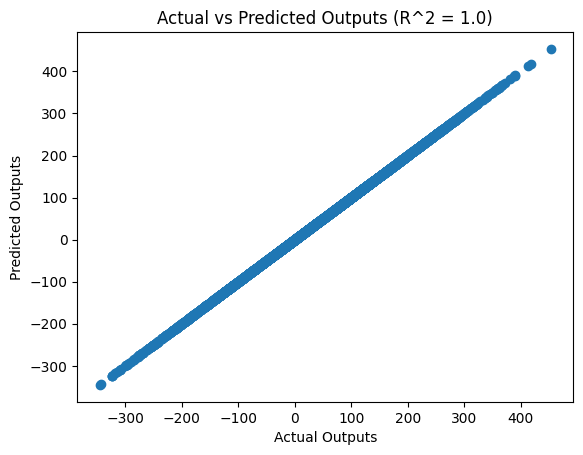

In [ ]:
# Visualization Test

if eq:
  eq.visualize_actual_vs_predicted()

# Data

- All data was originally collected in [this Google Sheet](https://docs.google.com/spreadsheets/d/1t9HqzVDHinJkV29-46H7Hvq82RXtvIA1s53FudI60SY/edit?usp=sharing)
  - Includes the results of the effect-of-noise and adaptive-vs-constant-alpha testing
  - Raw data can be found in the "[noise](https://docs.google.com/spreadsheets/d/1t9HqzVDHinJkV29-46H7Hvq82RXtvIA1s53FudI60SY/edit?gid=344099043#gid=344099043)" and "[alpha](https://docs.google.com/spreadsheets/d/1t9HqzVDHinJkV29-46H7Hvq82RXtvIA1s53FudI60SY/edit?gid=0#gid=0)" sheets
  - Aggregation/analysis of that data can be found in the and "[noise_analysis](https://docs.google.com/spreadsheets/d/1t9HqzVDHinJkV29-46H7Hvq82RXtvIA1s53FudI60SY/edit?gid=1500867377#gid=1500867377)" and "[alpha_analysis](https://docs.google.com/spreadsheets/d/1t9HqzVDHinJkV29-46H7Hvq82RXtvIA1s53FudI60SY/edit?gid=146546834#gid=146546834)" sheets